# Imports and datasets creation

In [ ]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from torch.autograd import Variable
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.datasets import make_moons, make_blobs, make_circles
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

float_Tensor = torch.FloatTensor
if cuda: float_Tensor = torch.cuda.FloatTensor
	
drop_last = True
shuffle = False

In [ ]:
def get_australian_np():
  column_names = ["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12", "f13", "f14", "label"]
  notebook_path = os.path.abspath("autoencoder_australian_clustering.ipynb")
  data_path = os.path.join(os.path.dirname(notebook_path),"drive/MyDrive/Diploma/australian.dat")
  df = pd.read_csv(data_path, delimiter=" ", header=None, names=column_names)
  data = df[["f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11", "f12", "f13", "f14"]]
  labels = df["label"]

  data = np.array(data)
  labels = np.array(labels)

  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  data = data.astype("float")
  label_encoder = LabelEncoder()
  labels = label_encoder.fit_transform(labels)
  labels = labels.astype("int")

  total_size = data.shape[0]
  random_permutation = np.random.permutation(np.arange(total_size))
  data = data[random_permutation]
  labels = labels[random_permutation]

  return data, labels

def get_australian_dataloader(batch_size=69):
	data, labels = get_australian_np()

	# Convert to tensor dataset
	data = torch.Tensor(data)
	data_shape = data.shape[1]
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

	return dataloader, data_shape

In [ ]:
australian_datapoints, australian_labels = get_australian_np()
australian_dataloader, australian_data_shape = get_australian_dataloader(batch_size=69)

# Autoencoder/Custom dataset/function declarations

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [ ]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [ ]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dimension, hl1_neurons, hl2_neurons, latent_dimension):
        super().__init__()

        # Encoder Model
        self.input_dimension = input_dimension
        self.hl1_neurons = hl1_neurons
        self.hl2_neurons = hl2_neurons
        self.latent_dimension = latent_dimension

        self.encoder_model = nn.Sequential(
          nn.Linear(input_dimension, self.hl1_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
        )
        
        # Latent Space
        self.latent_space = nn.Sequential(
          nn.Linear(self.hl2_neurons, self.latent_dimension),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.latent_dimension),
        )

        # Decoder Model
        self.decoder_model = nn.Sequential(
          nn.Linear(self.latent_dimension, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
          nn.Linear(self.hl2_neurons, self.hl1_neurons),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, input_dimension),
          nn.Sigmoid(),
        )

    def forward(self, x):
      x = self.encoder_model(x)
      x = self.latent_space(x)
      x = self.decoder_model(x)
      return x
  
    def encoder(self, x, device):
      x = torch.from_numpy(x).to(device)
      x= x.float()
      x = self.encoder_model(x)
      x = self.latent_space(x)
      return x.cpu().detach().numpy()

In [ ]:
def train_autoencoder(device, dataloader, autoencoder, epochs=500):
	criterion = nn.MSELoss().to(device)
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	loss_list = list()
	batch_size = 50
	
	autoencoder.train()
	for epoch in range(epochs):
		loss = 0
		for batch_index, (batch, labels) in enumerate(dataloader):
			# Data to the GPU (cuda)
			batch = Variable(batch.type(float_Tensor))
			
			# Indexes
			low_index = batch_index * batch_size
			high_index = (batch_index + 1) * batch_size
			
			# reset the gradients to zero
			optimizer.zero_grad()
			autoencoder.zero_grad()

			# compute reconstructions
			reconstructions = autoencoder(batch)

			# compute training reconstruction loss
			train_loss = criterion(reconstructions, batch)

			# compute accumulated gradients
			train_loss.backward()

			# perform parameter update based on current gradients
			optimizer.step()

			# add the mini-batch training loss to epoch loss
			loss += train_loss.item()

		loss = loss / len(dataloader)
		loss_list.append(loss)
		print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
		
	autoencoder.eval()
	return autoencoder, loss_list

# Clustering

In [ ]:
kmeans_2_clusters = KMeans(n_clusters=2, n_init=100).fit(australian_datapoints)
retrieved_labels_2_clusters = transform_clusters_to_labels(kmeans_2_clusters.labels_, australian_labels)

print("K_means greedy accuracy score for 2 clusters on initial space:",accuracy_score(australian_labels, retrieved_labels_2_clusters))
print("K_means hungarian accuracy score for 2 clusters on initial space:",cluster_accuracy(australian_labels, kmeans_2_clusters.labels_)[1])
print("K-means normalised mutual info score for 2 clusters on initial space:",normalized_mutual_info_score(australian_labels, kmeans_2_clusters.labels_))
print("K-means ARI for 2 clusters on initial space:",adjusted_rand_score(australian_labels, kmeans_2_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(australian_datapoints, kmeans_2_clusters.labels_))

K_means greedy accuracy score for 2 clusters on initial space: 0.86
K_means hungarian accuracy score for 2 clusters on initial space: 0.86
K-means normalised mutual info score for 2 clusters on initial space: 0.41582049156429396
K-means ARI for 2 clusters on initial space: 0.5179174657848519
K-means silhouette score for 2 clusters on initial space: 0.5007880991956327


In [ ]:
aggloClustering_2_clusters = AgglomerativeClustering(n_clusters=2).fit(australian_datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_2_clusters.labels_, australian_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(australian_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(australian_labels, aggloClustering_2_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(australian_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(australian_labels, aggloClustering_2_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(australian_datapoints, aggloClustering_2_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.855072463768116
Agglomerative clustering on initial space hungarian accuracy score: 0.855072463768116
Normalised mutual info score on agglomerative clustering on initial space: 0.4279177256697973
Agglomerative clustering ARI on initial space: 0.5035826470057695
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.24307309182524978


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(australian_datapoints)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 690 samples in 0.002s...
[t-SNE] Computed neighbors for 690 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 690 / 690
[t-SNE] Mean sigma: 0.324607
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.228878
[t-SNE] KL divergence after 400 iterations: 0.297894


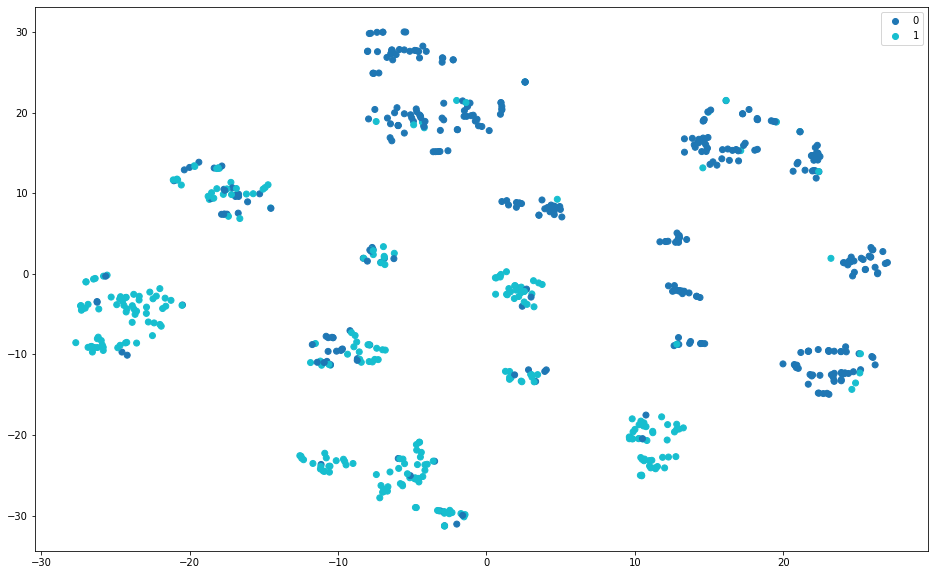

In [ ]:
dataset_labels = [0,1]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=australian_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [ ]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs=30, hl1_neurons=700, hl2_neurons=200, latent_dimension=10):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  agglo_silhouette_scores = []
  
  for i in range(10):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    # data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    # dataset_labels = [0,1,2,3,4,5,6,7,8,9]

    # plt.figure(figsize=(16,10))
    # scatterplot = plt.scatter(
    #     x=data_TSNE[:,0], y=data_TSNE[:,1],
    #     c=labels,
    #     cmap="tab10"
    # )

    # handles, _ = scatterplot.legend_elements(prop='colors')
    # plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=2, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 8 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=2).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)
    agglo_silhouette = k_means_silhouette_score = silhouette_score(latent_data, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)
    agglo_silhouette_scores.append(agglo_silhouette)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores, agglo_silhouette_scores]

In [ ]:
res = run_experiment(55, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8724637681159421
K_means hungarian accuracy score (initial space): 0.8724637681159421
Normalised mutual info score (initial space): 0.4463082894610139
ARI (initial space): 0.5542315878620666 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.140823
Epoch: 2/50, Loss: 0.105591
Epoch: 3/50, Loss: 0.094045
Epoch: 4/50, Loss: 0.088627
Epoch: 5/50, Loss: 0.085917
Epoch: 6/50, Loss: 0.084353
Epoch: 7/50, Loss: 0.083228
Epoch: 8/50, Loss: 0.082337
Epoch: 9/50, Loss: 0.081533
Epoch: 10/50, Loss: 0.080770
Epoch: 11/50, Loss: 0.080029
Epoch: 12/50, Loss: 0.079286
Epoch: 13/50, Loss: 0.078530
Epoch: 14/50, Loss: 0.077748
Epoch: 15/50, Loss: 0.076932
Epoch: 16/50, Loss: 0.076073
Epoch: 17/50, Loss: 0.075164
Epoch: 18/50, Loss: 0.074200
Epoch: 19/50, Loss: 0.073182
Epoch: 20/50, Loss: 0.072105
Epoch: 21

ValueError: ignored

In [ ]:
print(np.mean(res[6]))
print(np.std(res[6]))
print(np.mean(res[7]))
print(np.std(res[7]))

In [ ]:
results_for_k_5 = run_experiment(5, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 5 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.855072463768116
K_means hungarian accuracy score (initial space): 0.855072463768116
Normalised mutual info score (initial space): 0.4279177256697973
ARI (initial space): 0.5035826470057695 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.137734
Epoch: 2/50, Loss: 0.101678
Epoch: 3/50, Loss: 0.093093
Epoch: 4/50, Loss: 0.089474
Epoch: 5/50, Loss: 0.087367
Epoch: 6/50, Loss: 0.085964
Epoch: 7/50, Loss: 0.084709
Epoch: 8/50, Loss: 0.083333
Epoch: 9/50, Loss: 0.081918
Epoch: 10/50, Loss: 0.080726
Epoch: 11/50, Loss: 0.079751
Epoch: 12/50, Loss: 0.078869
Epoch: 13/50, Loss: 0.078015
Epoch: 14/50, Loss: 0.077158
Epoch: 15/50, Loss: 0.076315
Epoch: 16/50, Loss: 0.075471
Epoch: 17/50, Loss: 0.074589
Epoch: 18/50, Loss: 0.073651
Epoch: 19/50, Loss: 0.072655
Epoch: 20/50, Loss: 0.071601
Epoch: 21/50

In [ ]:
results_for_k_10 = run_experiment(10, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 10 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8333333333333334
K_means hungarian accuracy score (initial space): 0.8333333333333334
Normalised mutual info score (initial space): 0.3846188353540428
ARI (initial space): 0.4435986326584108 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.133613
Epoch: 2/50, Loss: 0.098793
Epoch: 3/50, Loss: 0.089865
Epoch: 4/50, Loss: 0.086416
Epoch: 5/50, Loss: 0.084607
Epoch: 6/50, Loss: 0.083278
Epoch: 7/50, Loss: 0.082283
Epoch: 8/50, Loss: 0.081489
Epoch: 9/50, Loss: 0.080768
Epoch: 10/50, Loss: 0.080049
Epoch: 11/50, Loss: 0.079330
Epoch: 12/50, Loss: 0.078596
Epoch: 13/50, Loss: 0.077843
Epoch: 14/50, Loss: 0.077061
Epoch: 15/50, Loss: 0.076242
Epoch: 16/50, Loss: 0.075377
Epoch: 17/50, Loss: 0.074463
Epoch: 18/50, Loss: 0.073493
Epoch: 19/50, Loss: 0.072463
Epoch: 20/50, Loss: 0.071369
Epoch: 21

In [ ]:
results_for_k_15 = run_experiment(15, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.855072463768116
K_means hungarian accuracy score (initial space): 0.855072463768116
Normalised mutual info score (initial space): 0.4279177256697973
ARI (initial space): 0.5035826470057695 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.131950
Epoch: 2/50, Loss: 0.098187
Epoch: 3/50, Loss: 0.088817
Epoch: 4/50, Loss: 0.085166
Epoch: 5/50, Loss: 0.083336
Epoch: 6/50, Loss: 0.082160
Epoch: 7/50, Loss: 0.081216
Epoch: 8/50, Loss: 0.080382
Epoch: 9/50, Loss: 0.079606
Epoch: 10/50, Loss: 0.078845
Epoch: 11/50, Loss: 0.078089
Epoch: 12/50, Loss: 0.077328
Epoch: 13/50, Loss: 0.076554
Epoch: 14/50, Loss: 0.075751
Epoch: 15/50, Loss: 0.074908
Epoch: 16/50, Loss: 0.074017
Epoch: 17/50, Loss: 0.073074
Epoch: 18/50, Loss: 0.072071
Epoch: 19/50, Loss: 0.071001
Epoch: 20/50, Loss: 0.069863
Epoch: 21/5

In [ ]:
results_for_k_20 = run_experiment(20, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.855072463768116
K_means hungarian accuracy score (initial space): 0.855072463768116
Normalised mutual info score (initial space): 0.4279177256697973
ARI (initial space): 0.5035826470057695 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.129561
Epoch: 2/50, Loss: 0.099227
Epoch: 3/50, Loss: 0.091773
Epoch: 4/50, Loss: 0.088815
Epoch: 5/50, Loss: 0.086831
Epoch: 6/50, Loss: 0.085300
Epoch: 7/50, Loss: 0.084188
Epoch: 8/50, Loss: 0.083313
Epoch: 9/50, Loss: 0.082489
Epoch: 10/50, Loss: 0.081689
Epoch: 11/50, Loss: 0.080900
Epoch: 12/50, Loss: 0.080097
Epoch: 13/50, Loss: 0.079274
Epoch: 14/50, Loss: 0.078417
Epoch: 15/50, Loss: 0.077516
Epoch: 16/50, Loss: 0.076563
Epoch: 17/50, Loss: 0.075548
Epoch: 18/50, Loss: 0.074469
Epoch: 19/50, Loss: 0.073324
Epoch: 20/50, Loss: 0.072111
Epoch: 21/5

In [ ]:
results_for_k_25 = run_experiment(25, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8652173913043478
K_means hungarian accuracy score (initial space): 0.8652173913043478
Normalised mutual info score (initial space): 0.4358333713714687
ARI (initial space): 0.5328618015767846 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.141317
Epoch: 2/50, Loss: 0.106084
Epoch: 3/50, Loss: 0.095116
Epoch: 4/50, Loss: 0.089268
Epoch: 5/50, Loss: 0.086366
Epoch: 6/50, Loss: 0.084650
Epoch: 7/50, Loss: 0.083456
Epoch: 8/50, Loss: 0.082557
Epoch: 9/50, Loss: 0.081724
Epoch: 10/50, Loss: 0.080940
Epoch: 11/50, Loss: 0.080169
Epoch: 12/50, Loss: 0.079388
Epoch: 13/50, Loss: 0.078585
Epoch: 14/50, Loss: 0.077743
Epoch: 15/50, Loss: 0.076851
Epoch: 16/50, Loss: 0.075908
Epoch: 17/50, Loss: 0.074911
Epoch: 18/50, Loss: 0.073859
Epoch: 19/50, Loss: 0.072745
Epoch: 20/50, Loss: 0.071564
Epoch: 21

In [ ]:
results_for_k_30 = run_experiment(30, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.855072463768116
K_means hungarian accuracy score (initial space): 0.855072463768116
Normalised mutual info score (initial space): 0.4170586260074089
ARI (initial space): 0.5035933708821814 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.132736
Epoch: 2/50, Loss: 0.099558
Epoch: 3/50, Loss: 0.090336
Epoch: 4/50, Loss: 0.086242
Epoch: 5/50, Loss: 0.084225
Epoch: 6/50, Loss: 0.082760
Epoch: 7/50, Loss: 0.081588
Epoch: 8/50, Loss: 0.080572
Epoch: 9/50, Loss: 0.079692
Epoch: 10/50, Loss: 0.078895
Epoch: 11/50, Loss: 0.078137
Epoch: 12/50, Loss: 0.077380
Epoch: 13/50, Loss: 0.076598
Epoch: 14/50, Loss: 0.075788
Epoch: 15/50, Loss: 0.074944
Epoch: 16/50, Loss: 0.074058
Epoch: 17/50, Loss: 0.073127
Epoch: 18/50, Loss: 0.072145
Epoch: 19/50, Loss: 0.071111
Epoch: 20/50, Loss: 0.070021
Epoch: 21/5

In [ ]:
results_for_k_35 = run_experiment(35, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8623188405797102
K_means hungarian accuracy score (initial space): 0.8623188405797102
Normalised mutual info score (initial space): 0.42470674197486863
ARI (initial space): 0.5244082613569434 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.130139
Epoch: 2/50, Loss: 0.099564
Epoch: 3/50, Loss: 0.091187
Epoch: 4/50, Loss: 0.087492
Epoch: 5/50, Loss: 0.085351
Epoch: 6/50, Loss: 0.083881
Epoch: 7/50, Loss: 0.082591
Epoch: 8/50, Loss: 0.081483
Epoch: 9/50, Loss: 0.080536
Epoch: 10/50, Loss: 0.079694
Epoch: 11/50, Loss: 0.078905
Epoch: 12/50, Loss: 0.078113
Epoch: 13/50, Loss: 0.077294
Epoch: 14/50, Loss: 0.076445
Epoch: 15/50, Loss: 0.075558
Epoch: 16/50, Loss: 0.074628
Epoch: 17/50, Loss: 0.073647
Epoch: 18/50, Loss: 0.072610
Epoch: 19/50, Loss: 0.071513
Epoch: 20/50, Loss: 0.070353
Epoch: 2

In [ ]:
results_for_k_40 = run_experiment(40, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8608695652173913
K_means hungarian accuracy score (initial space): 0.8608695652173913
Normalised mutual info score (initial space): 0.41402398350204966
ARI (initial space): 0.5201358558415248 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.134430
Epoch: 2/50, Loss: 0.101807
Epoch: 3/50, Loss: 0.090582
Epoch: 4/50, Loss: 0.086490
Epoch: 5/50, Loss: 0.084331
Epoch: 6/50, Loss: 0.082895
Epoch: 7/50, Loss: 0.081793
Epoch: 8/50, Loss: 0.080903
Epoch: 9/50, Loss: 0.080103
Epoch: 10/50, Loss: 0.079323
Epoch: 11/50, Loss: 0.078556
Epoch: 12/50, Loss: 0.077796
Epoch: 13/50, Loss: 0.077019
Epoch: 14/50, Loss: 0.076225
Epoch: 15/50, Loss: 0.075404
Epoch: 16/50, Loss: 0.074545
Epoch: 17/50, Loss: 0.073636
Epoch: 18/50, Loss: 0.072671
Epoch: 19/50, Loss: 0.071648
Epoch: 20/50, Loss: 0.070561
Epoch: 2

In [ ]:
results_for_k_45 = run_experiment(45, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8695652173913043
K_means hungarian accuracy score (initial space): 0.8695652173913043
Normalised mutual info score (initial space): 0.43767258059054975
ARI (initial space): 0.5455681416638155 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.133744
Epoch: 2/50, Loss: 0.099173
Epoch: 3/50, Loss: 0.088537
Epoch: 4/50, Loss: 0.084617
Epoch: 5/50, Loss: 0.082613
Epoch: 6/50, Loss: 0.081365
Epoch: 7/50, Loss: 0.080374
Epoch: 8/50, Loss: 0.079542
Epoch: 9/50, Loss: 0.078789
Epoch: 10/50, Loss: 0.078068
Epoch: 11/50, Loss: 0.077352
Epoch: 12/50, Loss: 0.076624
Epoch: 13/50, Loss: 0.075871
Epoch: 14/50, Loss: 0.075086
Epoch: 15/50, Loss: 0.074259
Epoch: 16/50, Loss: 0.073384
Epoch: 17/50, Loss: 0.072459
Epoch: 18/50, Loss: 0.071484
Epoch: 19/50, Loss: 0.070454
Epoch: 20/50, Loss: 0.069365
Epoch: 2

In [ ]:
results_for_k_50 = run_experiment(50, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8666666666666667
K_means hungarian accuracy score (initial space): 0.8666666666666667
Normalised mutual info score (initial space): 0.4328498261832301
ARI (initial space): 0.5370901054514612 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.132485
Epoch: 2/50, Loss: 0.098564
Epoch: 3/50, Loss: 0.089227
Epoch: 4/50, Loss: 0.085676
Epoch: 5/50, Loss: 0.083922
Epoch: 6/50, Loss: 0.082757
Epoch: 7/50, Loss: 0.081831
Epoch: 8/50, Loss: 0.080994
Epoch: 9/50, Loss: 0.080233
Epoch: 10/50, Loss: 0.079505
Epoch: 11/50, Loss: 0.078770
Epoch: 12/50, Loss: 0.078002
Epoch: 13/50, Loss: 0.077196
Epoch: 14/50, Loss: 0.076357
Epoch: 15/50, Loss: 0.075488
Epoch: 16/50, Loss: 0.074583
Epoch: 17/50, Loss: 0.073635
Epoch: 18/50, Loss: 0.072634
Epoch: 19/50, Loss: 0.071575
Epoch: 20/50, Loss: 0.070453
Epoch: 21

In [ ]:
results_for_k_55 = run_experiment(55, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8710144927536232
K_means hungarian accuracy score (initial space): 0.8710144927536232
Normalised mutual info score (initial space): 0.45339399093422644
ARI (initial space): 0.5499597787337382 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.133692
Epoch: 2/50, Loss: 0.097128
Epoch: 3/50, Loss: 0.088277
Epoch: 4/50, Loss: 0.085087
Epoch: 5/50, Loss: 0.083535
Epoch: 6/50, Loss: 0.082416
Epoch: 7/50, Loss: 0.081473
Epoch: 8/50, Loss: 0.080630
Epoch: 9/50, Loss: 0.079836
Epoch: 10/50, Loss: 0.079065
Epoch: 11/50, Loss: 0.078316
Epoch: 12/50, Loss: 0.077585
Epoch: 13/50, Loss: 0.076850
Epoch: 14/50, Loss: 0.076089
Epoch: 15/50, Loss: 0.075295
Epoch: 16/50, Loss: 0.074463
Epoch: 17/50, Loss: 0.073586
Epoch: 18/50, Loss: 0.072659
Epoch: 19/50, Loss: 0.071681
Epoch: 20/50, Loss: 0.070648
Epoch: 2

In [ ]:
results_for_k_60 = run_experiment(60, australian_dataloader, australian_data_shape, australian_datapoints, australian_labels, 50, hl1_neurons=500, hl2_neurons=300, latent_dimension=5)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8695652173913043
K_means hungarian accuracy score (initial space): 0.8695652173913043
Normalised mutual info score (initial space): 0.4431729180325685
ARI (initial space): 0.5456491331941292 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.134757
Epoch: 2/50, Loss: 0.099000
Epoch: 3/50, Loss: 0.089021
Epoch: 4/50, Loss: 0.085369
Epoch: 5/50, Loss: 0.083563
Epoch: 6/50, Loss: 0.082308
Epoch: 7/50, Loss: 0.081284
Epoch: 8/50, Loss: 0.080407
Epoch: 9/50, Loss: 0.079625
Epoch: 10/50, Loss: 0.078873
Epoch: 11/50, Loss: 0.078123
Epoch: 12/50, Loss: 0.077359
Epoch: 13/50, Loss: 0.076572
Epoch: 14/50, Loss: 0.075753
Epoch: 15/50, Loss: 0.074895
Epoch: 16/50, Loss: 0.073994
Epoch: 17/50, Loss: 0.073044
Epoch: 18/50, Loss: 0.072038
Epoch: 19/50, Loss: 0.070972
Epoch: 20/50, Loss: 0.069847
Epoch: 21

In [ ]:
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_5[0][i]
  kmeans_acc[i][1] = results_for_k_10[0][i]
  kmeans_acc[i][2] = results_for_k_15[0][i]
  kmeans_acc[i][3] = results_for_k_20[0][i]
  kmeans_acc[i][4] = results_for_k_25[0][i]
  kmeans_acc[i][5] = results_for_k_30[0][i]
  kmeans_acc[i][6] = results_for_k_35[0][i]
  kmeans_acc[i][7] = results_for_k_40[0][i]
  kmeans_acc[i][8] = results_for_k_45[0][i]
  kmeans_acc[i][9] = results_for_k_50[0][i]
  kmeans_acc[i][10] = results_for_k_55[0][i]
  kmeans_acc[i][11] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_5[1][i]
  kmeans_NMI[i][1] = results_for_k_10[1][i]
  kmeans_NMI[i][2] = results_for_k_15[1][i]
  kmeans_NMI[i][3] = results_for_k_20[1][i]
  kmeans_NMI[i][4] = results_for_k_25[1][i]
  kmeans_NMI[i][5] = results_for_k_30[1][i]
  kmeans_NMI[i][6] = results_for_k_35[1][i]
  kmeans_NMI[i][7] = results_for_k_40[1][i]
  kmeans_NMI[i][8] = results_for_k_45[1][i]
  kmeans_NMI[i][9] = results_for_k_50[1][i]
  kmeans_NMI[i][10] = results_for_k_55[1][i]
  kmeans_NMI[i][11] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_5[2][i]
  kmeans_ARI[i][1] = results_for_k_10[2][i]
  kmeans_ARI[i][2] = results_for_k_15[2][i]
  kmeans_ARI[i][3] = results_for_k_20[2][i]
  kmeans_ARI[i][4] = results_for_k_25[2][i]
  kmeans_ARI[i][5] = results_for_k_30[2][i]
  kmeans_ARI[i][6] = results_for_k_35[2][i]
  kmeans_ARI[i][7] = results_for_k_40[2][i]
  kmeans_ARI[i][8] = results_for_k_45[2][i]
  kmeans_ARI[i][9] = results_for_k_50[2][i]
  kmeans_ARI[i][10] = results_for_k_55[2][i]
  kmeans_ARI[i][11] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_5[3][i]
  agglo_acc[i][1] = results_for_k_10[3][i]
  agglo_acc[i][2] = results_for_k_15[3][i]
  agglo_acc[i][3] = results_for_k_20[3][i]
  agglo_acc[i][4] = results_for_k_25[3][i]
  agglo_acc[i][5] = results_for_k_30[3][i]
  agglo_acc[i][6] = results_for_k_35[3][i]
  agglo_acc[i][7] = results_for_k_40[3][i]
  agglo_acc[i][8] = results_for_k_45[3][i]
  agglo_acc[i][9] = results_for_k_50[3][i]
  agglo_acc[i][10] = results_for_k_55[3][i]
  agglo_acc[i][11] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_5[4][i]
  agglo_NMI[i][1] = results_for_k_10[4][i]
  agglo_NMI[i][2] = results_for_k_15[4][i]
  agglo_NMI[i][3] = results_for_k_20[4][i]
  agglo_NMI[i][4] = results_for_k_25[4][i]
  agglo_NMI[i][5] = results_for_k_30[4][i]
  agglo_NMI[i][6] = results_for_k_35[4][i]
  agglo_NMI[i][7] = results_for_k_40[4][i]
  agglo_NMI[i][8] = results_for_k_45[4][i]
  agglo_NMI[i][9] = results_for_k_50[4][i]
  agglo_NMI[i][10] = results_for_k_55[4][i]
  agglo_NMI[i][11] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_5[5][i]
  agglo_ARI[i][1] = results_for_k_10[5][i]
  agglo_ARI[i][2] = results_for_k_15[5][i]
  agglo_ARI[i][3] = results_for_k_20[5][i]
  agglo_ARI[i][4] = results_for_k_25[5][i]
  agglo_ARI[i][5] = results_for_k_30[5][i]
  agglo_ARI[i][6] = results_for_k_35[5][i]
  agglo_ARI[i][7] = results_for_k_40[5][i]
  agglo_ARI[i][8] = results_for_k_45[5][i]
  agglo_ARI[i][9] = results_for_k_50[5][i]
  agglo_ARI[i][10] = results_for_k_55[5][i]
  agglo_ARI[i][11] = results_for_k_60[5][i]


Text(0.5, 0, 'K')

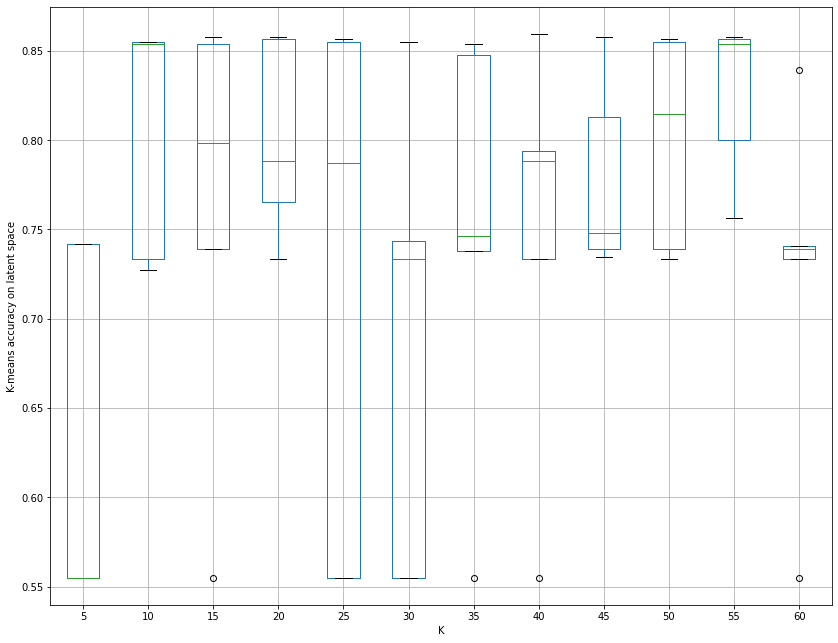

In [ ]:
columns = ['5', '10','15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

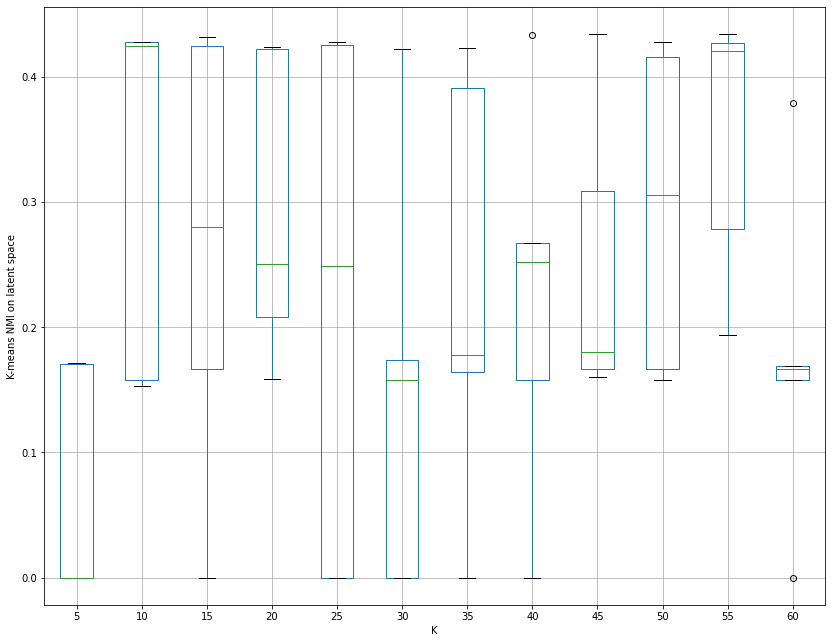

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

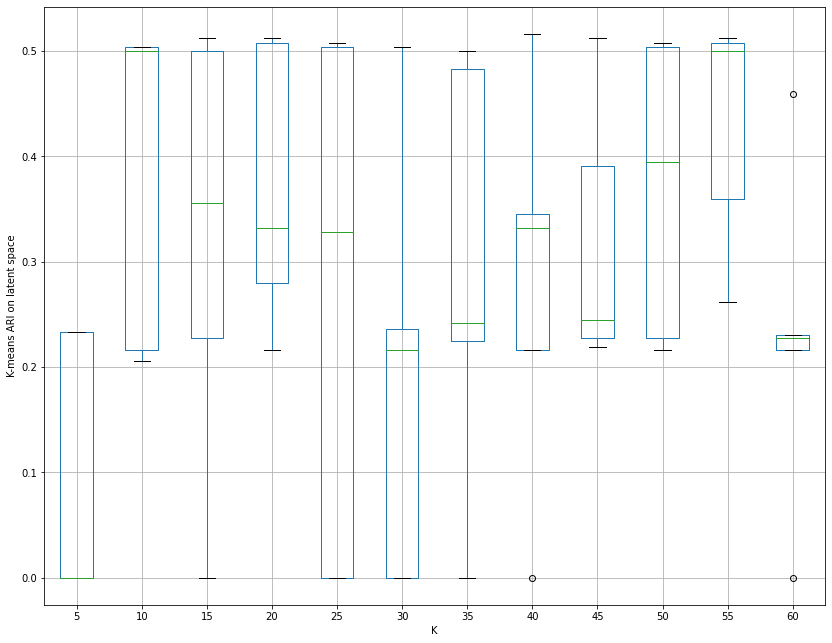

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

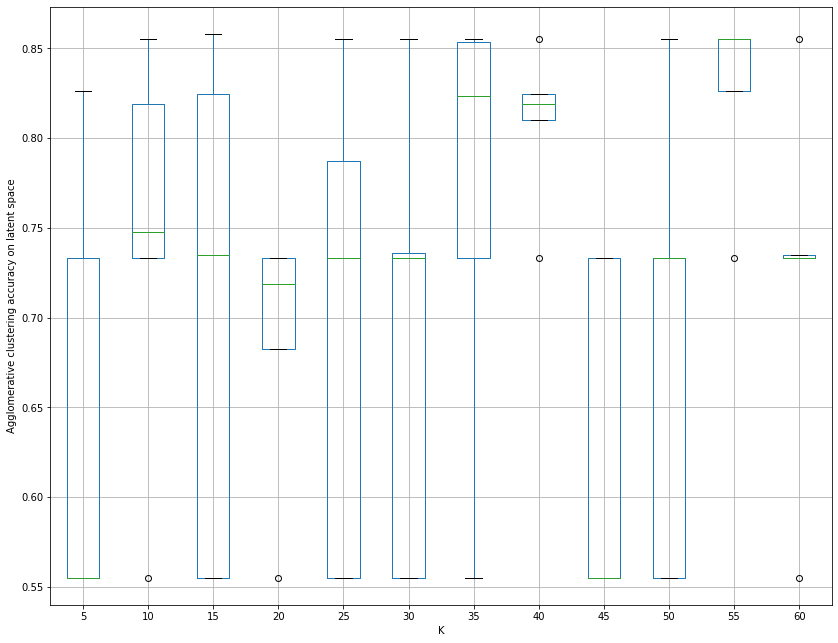

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

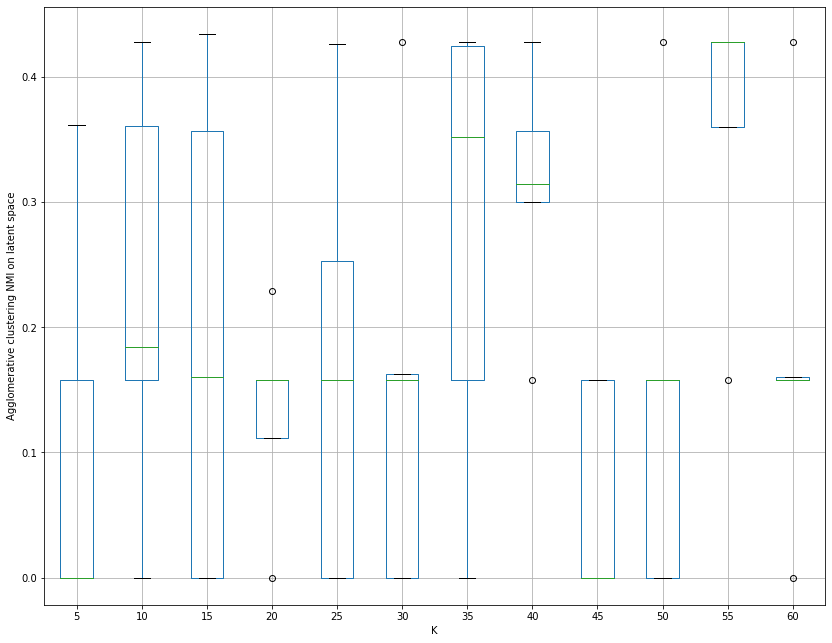

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

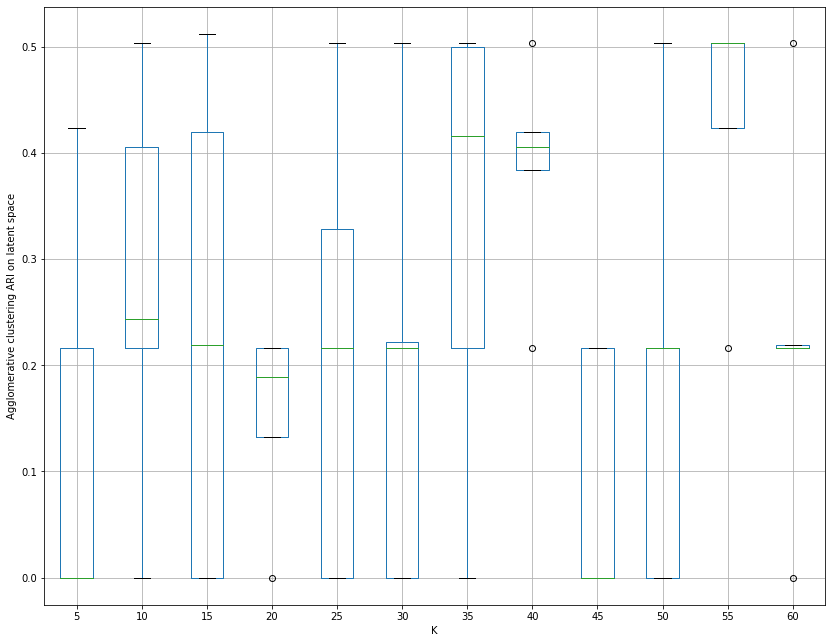

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K') 